In [29]:
# import the liraries 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 


from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR, SVR 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, PolynomialFeatures,LabelEncoder
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, IsolationForest, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV, RandomizedSearchCV, train_test_split


In [15]:
## load the data 
cars=pd.read_csv('cheki_cars_cleaned_new.csv')
cars.head()

,make,model,location,color,price_in_Ksh,year_of_manufacture,transmission,mileage_in_km,fuel,foreign_local,review_score
0,mazda,demio,Nairobi,silver,600000,2013,Automatic,135000.0,Petrol,Foreign,3.714286
1,toyota,axio,Nairobi,silver,1100000,2013,Automatic,72000.0,Petrol,Foreign,3.600000
2,mercedes-benz,cla-class,Mombasa,silver,3600000,2013,Automatic,NaN,Petrol,Foreign,3.000000
3,mercedes-benz,cla-class,Mombasa,silver,3600000,2013,Automatic,NaN,Petrol,Foreign,3.000000
4,mazda,axela,Mombasa,black,1050000,2013,Automatic,58000.0,Petrol,Foreign,3.333333


Skewness: 2.974662
Kurtosis: 12.151408


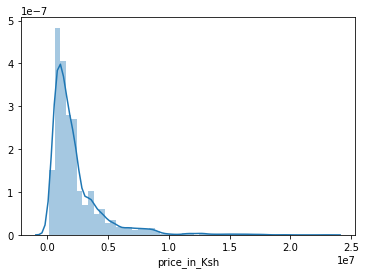

In [9]:
## data cleaning for ml 
### here we shall handle missing values , do correct encoding and check for outliers in price,mileage and year of manufacture 
# 1. Check skew 
sns.distplot(cars['price_in_Ksh'])
#skewness and kurtosis
print("Skewness: %f" % cars['price_in_Ksh'].skew())
print("Kurtosis: %f" % cars['price_in_Ksh'].kurt())

"""
We can observe that the distribution of prices shows a high positive skewness 
to the left (skew > 1). A kurtosis value of 12 is extremely high, meaning that
there is a profusion of outliers in the dataset. We shall do sth about it in abit .
"""

<AxesSubplot:xlabel='year_of_manufacture'>

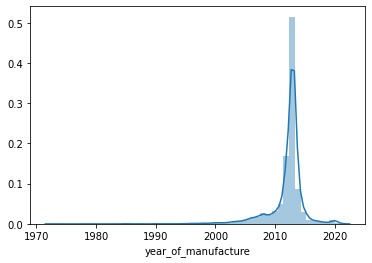

In [10]:
## distribution of the year of manufacture 
sns.distplot(cars['year_of_manufacture'])

<AxesSubplot:xlabel='price_in_Ksh'>

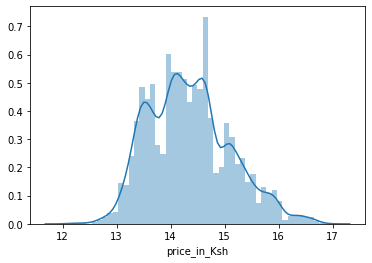

In [16]:
## for price we shall do a log transformation 

#applying log transformation
cars['price_in_Ksh'] = np.log(cars['price_in_Ksh'])
sns.distplot(cars['price_in_Ksh'])

In [4]:
## feature engineering 

In [20]:
# LABEL ENCODING
features = ['make','model','location','color','transmission','fuel','foreign_local']
label_encoded_features = {}

for feature in features:
    label_encoded_features[feature] =LabelEncoder()
    label_encoded_features[feature] = label_encoded_features[feature].fit(cars[feature])
    cars[feature] = label_encoded_features[feature].transform(cars[feature])

In [21]:
cars.head()

,make,model,location,color,price_in_Ksh,year_of_manufacture,transmission,mileage_in_km,fuel,foreign_local,review_score
0,20,118,7,14,13.304685,2013,0,135000.0,3,1,3.714286
1,32,54,7,14,13.910821,2013,0,72000.0,3,1,3.600000
2,21,92,5,14,15.096444,2013,0,NaN,3,1,3.000000
3,21,92,5,14,15.096444,2013,0,NaN,3,1,3.000000
4,20,53,5,2,13.864301,2013,0,58000.0,3,1,3.333333


In [28]:
## filling with missing values for mileage 
mean_milleage=cars['mileage_in_km'].mean()
cars.fillna(value=mean_milleage,inplace=True)

cars_predictors=cars.drop('price_in_Ksh',axis=1)
cars_predictors.head()

,make,model,location,color,year_of_manufacture,transmission,mileage_in_km,fuel,foreign_local,review_score
0,20,118,7,14,2013,0,135000.000000,3,1,3.714286
1,32,54,7,14,2013,0,72000.000000,3,1,3.600000
2,21,92,5,14,2013,0,87087.918037,3,1,3.000000
3,21,92,5,14,2013,0,87087.918037,3,1,3.000000
4,20,53,5,2,2013,0,58000.000000,3,1,3.333333


In [31]:
## ## scalling the data 
scaler=RobustScaler()
X=scaler.fit_transform(cars_predictors)
predictors=pd.DataFrame(X)
predictors.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.000000,-0.656250,0.0,0.5,0.0,0.0,1.798612,0.0,0.0,0.040816
1,0.090909,-1.156250,0.0,0.5,0.0,0.0,-0.562066,0.0,0.0,-0.057143
2,-0.909091,-0.859375,-1.0,0.5,0.0,0.0,0.003294,0.0,0.0,-0.571429
3,-0.909091,-0.859375,-1.0,0.5,0.0,0.0,0.003294,0.0,0.0,-0.571429
4,-1.000000,-1.164062,-1.0,-0.5,0.0,0.0,-1.086661,0.0,0.0,-0.285714


In [35]:
### outliers 
anomalies = IsolationForest(contamination=0.02).fit_predict(predictors)
print("Rows with anomalies: ", np.where(anomalies<1))

## we can decide to drop the outliers but first let us fit a model with the outliers and see how it performs 

Rows with anomalies:  (array([  80,   82,  162,  170,  179,  196,  226,  243,  244,  248,  280,
        286,  306,  308,  389,  482,  767,  769,  774,  775,  795,  929,
       1080, 1102, 1142, 1324, 1349, 1415, 1434, 1519, 1523, 1526, 1598,
       1718, 1720, 1721, 1724, 1774, 1810, 1877, 1939, 2235, 2357, 2582,
       2587, 2593, 2594, 2605, 2613, 2614, 2755, 2771, 2791, 2955, 2957,
       3073, 3096, 3157, 3174, 3292, 3318, 3320, 3864, 3865, 3894, 4154,
       4436, 4487, 4489, 4491, 4502, 4503, 4505, 4519, 4936, 4941, 4942,
       4944, 4952, 4958, 5045, 5049, 5051, 5052, 5053, 5055, 5057, 5058,
       5059, 5060, 5062, 5064, 5065, 5066, 5067, 5068, 5069, 5071, 5072,
       5073, 5074, 5075, 5076, 5077, 5079, 5081, 5082, 5083, 5084, 5085,
       5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096,
       5372, 5428, 5435, 5608, 5704, 6310, 6446, 6460, 6463, 6704, 7050,
       7054, 7056, 7192, 7199, 7300, 7347, 7348, 7349, 7350, 7351, 7352,
       7353, 7354, 7362, 736

## Model selection 
Here we shall compare the models with cross validation since the dataset has a lot of variety 

In [36]:
X=predictors
y=cars['price_in_Ksh']

In [55]:
models = []
pipe_linear = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), Ridge(alpha=100))
pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.015))
model_rf = RandomForestRegressor(n_estimators=1000)
model_ada = AdaBoostRegressor(n_estimators=100, learning_rate=0.02, loss="linear")
model_bag = BaggingRegressor(n_estimators=100, max_features=2.0)
model_dt =DecisionTreeRegressor()

models.append(('LR',pipe_linear))
models.append(('ridge',pipe_ridge))
models.append(('lasso', pipe_lasso))
models.append(('ada_boost', model_ada))
models.append(('RF',model_rf))
models.append(('dt',model_dt))  
print(models)

[('LR', Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])), ('ridge', Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('ridge', Ridge(alpha=100))])), ('lasso', Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=0.015))])), ('ada_boost', AdaBoostRegressor(learning_rate=0.02, n_estimators=100)), ('RF', RandomForestRegressor(n_estimators=1000)), ('dt', DecisionTreeRegressor())]


In [56]:

import warnings
warnings.filterwarnings("ignore")

names = []
scores = []

for name,model in models:
    score = cross_val_score(model, X, y, cv=10, scoring='r2')
    print(name,score)
    scores.append(score.mean())
    names.append(name)

cv_score_models = pd.DataFrame({'Name': names, 'Score': scores})
cv_score_models

LR [ 0.31775234  0.22506395  0.24351253  0.28104688  0.33502639  0.30433294
  0.32322693  0.31667939  0.12027528 -0.67788274]
ridge [ 0.26411995  0.16064988  0.14570515  0.18423691  0.23823277  0.21422362
  0.20981626  0.23122173 -0.01777195 -0.78832639]
lasso [ 0.31823059  0.22152284  0.25200396  0.28134254  0.31948442  0.28258678
  0.29005266  0.29105491  0.10940298 -0.59786443]
ada_boost [ 0.26103571  0.18718581  0.22423781  0.27834219  0.27454944  0.2280636
  0.23818681  0.27088474  0.1985898  -0.35536109]
RF [0.91285728 0.87101426 0.89490191 0.87742096 0.90121606 0.88152303
 0.92385152 0.90193243 0.91290328 0.31413117]
dt [ 0.87265017  0.7692018   0.83007111  0.77783376  0.82924586  0.83440367
  0.86493058  0.82470239  0.85391986 -0.30548927]


,Name,Score
0,LR,0.178903
1,ridge,0.084211
2,lasso,0.176782
3,ada_boost,0.180571
4,RF,0.839175
5,dt,0.715147


Text(0.5, 1.0, 'TREE BASED MODELS VS LINEAR MODELS COMPARISON')

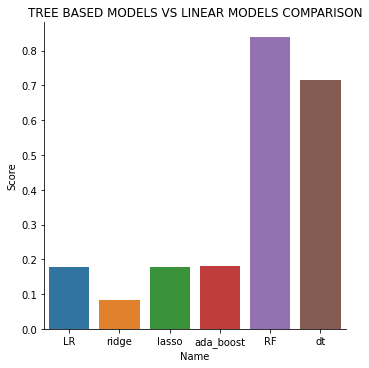

In [69]:
sns.catplot(x='Name',y='Score',data=cv_score_models,kind='bar')
plt.title('TREE BASED MODELS VS LINEAR MODELS COMPARISON')

In [64]:
model = SVR(C=1,kernel="poly", degree=2)
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

print(scores, scores.mean())

[-0.37032204 -0.34574089 -0.35142612 -0.38151428 -1.00358047] -0.4905167591161609


In [65]:
model_rf = RandomForestRegressor(n_estimators=100)
scores = cross_val_score(model_rf, X, y, cv=5, scoring='neg_mean_squared_error')

print(scores, scores.mean())

[-0.05156589 -0.05415327 -0.05193819 -0.04018084 -0.31253247] -0.10207413279397677


### model selection inference 
1. Tree based methods are far superior than linear models in fitting the data 
2. Random Forest produces the highest cross val score so we shall proceed 

## hyper parameter tuning 

In [71]:

from pprint import pprint
# the following are the parameters of the random forest that we shall consider 
pprint(model_rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [74]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 900, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [1,2,4,5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [1, 2, 4, 5, 10],
 'n_estimators': [100, 188, 277, 366, 455, 544, 633, 722, 811, 900]}


In [76]:
## random search cv 
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores by specifying n_jobs=-1
rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid,
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [1, 2, 4, 5, 10],
                                        'n_estimators': [100, 188, 277, 366,
                                                         455, 544, 633, 722,
                                                         811, 900]},
                   random_state=42, verbose=2)

In [77]:
rf_random.best_params_

{'n_estimators': 277,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [78]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,20, None],
    'max_features': [2, 3],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split': [8, 10, 12,14],
    'n_estimators': [100, 200,250,300]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [79]:
grid_search.fit(X,y)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 13.0min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, None],
                         'max_features': [2, 3],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [8, 10, 12, 14],
                         'n_estimators': [100, 200, 250, 300]},
             verbose=2)

In [80]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 200}

In [82]:
##3 now using these best parameters to get a cross val score 
model_rf_updated=RandomForestRegressor(**grid_search.best_params_)
scores = cross_val_score(model_rf_updated, X, y, cv=10, scoring='r2')

print(scores, scores.mean())

[0.87511855 0.84877807 0.86358735 0.85231355 0.89670578 0.83299124
 0.89929422 0.86896438 0.89510788 0.42196734] 0.8254828371071896


## Model Evaluation 


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(7374, 10) (1844, 10) (7374,) (1844,)


In [84]:
model = model_rf_updated.fit(X_train, y_train)
y_pred = model.predict((X_test))

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.05415849471204261
0.9070090540175607


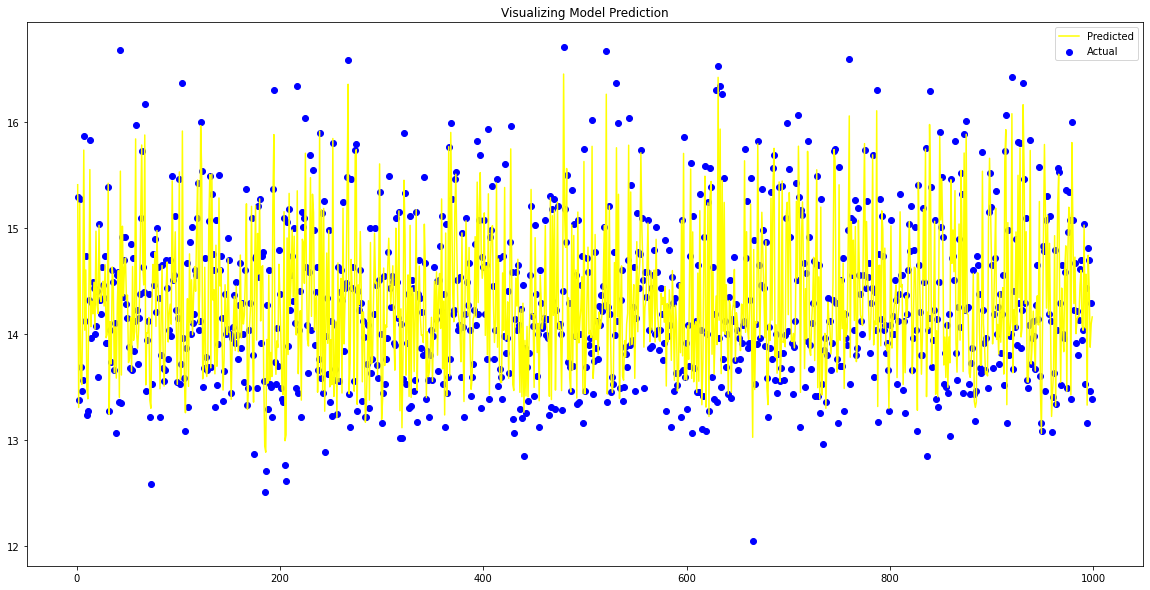

In [92]:
## visualize the predictions from the model 
x = np.arange(len(y_pred))[1:1000]
plt.figure(figsize=(20,10))

plt.plot(x, y_pred[1:1000], label="Predicted", color="Yellow")
plt.scatter(x, y_test[1:1000], label="Actual", color="Blue")
plt.title("Visualizing Model Prediction")
plt.legend()

plt.show()

In [93]:
## plotting feature importance 
model.feature_importances_

array([0.13033154, 0.30259517, 0.00969036, 0.02723307, 0.19698104,
       0.0102039 , 0.05150062, 0.09798796, 0.03617379, 0.13730254])

<AxesSubplot:>

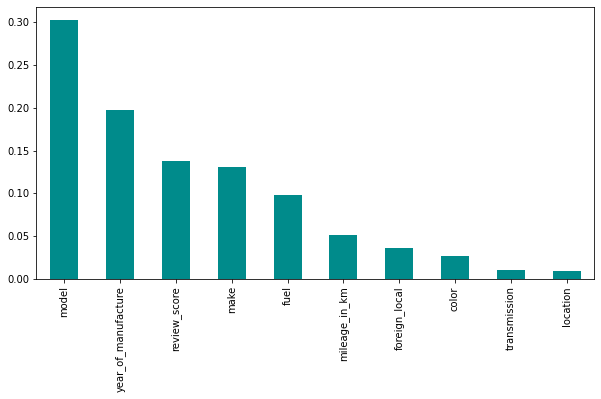

In [115]:
plt.figure(figsize=(10,5))
# features=cars.drop('price_in_Ksh',axis=1)
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(10).plot(kind='bar',color='darkcyan')
